# KPI 19

In [152]:
import pandas as pd
import matplotlib.pyplot as plt

In [153]:
df = pd.read_csv('./data/rota3_SBCT-SBSP.csv')
df

,Unnamed: 0,indicat,time,lat,lon,alt,head,speed,equip,reg,plan_dep,plan_arr,real_arr,id_iata,id_icao
0,1,912790636,2024-07-31 00:06:40,-25.53185,-49.17320,0.0,45.0,13.0,B737,PRGEC,SBCT,SBSP,SBSP,G31137,GLO1137
1,2,912790636,2024-07-31 00:06:47,-25.53152,-49.17286,0.0,39.0,13.0,B737,PRGEC,SBCT,SBSP,SBSP,G31137,GLO1137
2,3,912790636,2024-07-31 00:06:52,-25.53127,-49.17281,0.0,5.0,12.0,B737,PRGEC,SBCT,SBSP,SBSP,G31137,GLO1137
3,4,912790636,2024-07-31 00:06:57,-25.53100,-49.17300,0.0,320.0,12.0,B737,PRGEC,SBCT,SBSP,SBSP,G31137,GLO1137
4,5,912790636,2024-07-31 00:07:02,-25.53078,-49.17325,0.0,315.0,13.0,B737,PRGEC,SBCT,SBSP,SBSP,G31137,GLO1137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864,865,913039846,2024-07-31 22:35:15,-23.62221,-46.65955,2250.0,147.0,130.0,B737,PRGEA,SBCT,SBSP,SBSP,G31127,GLO1127
865,866,913039846,2024-07-31 22:35:24,-23.62642,-46.65666,0.0,149.0,115.0,B737,PRGEA,SBCT,SBSP,SBSP,G31127,GLO1127
866,867,913039846,2024-07-31 22:35:30,-23.62889,-46.65494,0.0,146.0,86.0,B737,PRGEA,SBCT,SBSP,SBSP,G31127,GLO1127
867,868,913039846,2024-07-31 22:35:36,-23.63050,-46.65382,0.0,146.0,55.0,B737,PRGEA,SBCT,SBSP,SBSP,G31127,GLO1127


In [154]:
df = df.drop_duplicates(subset=['indicat', 'time'])

In [155]:
def calculate_vertical_speed(df):
    df['time'] = pd.to_datetime(df['time'])
    vertical_speed = [0]
    for i in range(1,len(df)):
        delta_time = (df.iloc[i].time - df.iloc[i-1].time).total_seconds()/60 # total minutos
        delta_alt = df.iloc[i].alt - df.iloc[i-1].alt
        vertical_speed.append(delta_alt / delta_time if delta_time != 0 else 0)
    return vertical_speed

In [156]:
## VOOS: GLO1137, GLO1107, GLO1127
id_icao = 'GLO1107'
t1 = df[df['id_icao']==id_icao]
t1 = t1.sort_values(by='time')

In [157]:
t1['vertical_speed'] = calculate_vertical_speed(t1)

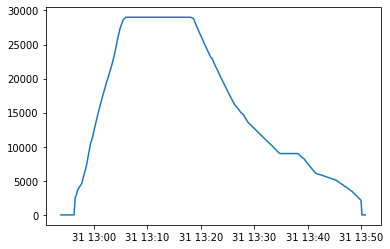

In [158]:
plt.plot(t1.time, t1.alt)

In [159]:
# Definição de Parâmetros
TOC = t1.alt.max()
TOC_box_lim = TOC * 90/100
min_alt = 1800
level_band = 200
box_time = 5*60 # conversão de 5 minutos para segundos
min_level_time = 20 # segundos
vertical_speed_band = 300

In [160]:
def identify_initial_segment_point(df, level_band, vertical_speed_band):
    df['time'] = pd.to_datetime(df['time'])
    is_initial = []
    for i in range(len(df)-1):
        if df.iloc[i].alt - df.iloc[i+1].alt <= level_band and df.iloc[i].vertical_speed - df.iloc[i+1].vertical_speed <= vertical_speed_band:
            is_initial.append(True)
        else:
            is_initial.append(False)
    is_initial.append(False)
    return is_initial

In [161]:
if id_icao == 'GLO1137':
    percent_exclusion = 18/100
elif id_icao == 'GLO1107':
    percent_exclusion = 12/100
elif id_icao == 'GLO1127':
    percent_exclusion = 19/100

proc_t = t1[t1['alt']>=min_alt] # considerar a partir de altitude minima
proc_t = proc_t.iloc[int(len(t1)*percent_exclusion):] # desconsidera a parte descendente da trajetória - passo seria desnecessário se a distância entre os aeródromos fosse maior

In [162]:
proc_t['initial_seg_point'] = identify_initial_segment_point(proc_t, level_band, vertical_speed_band)

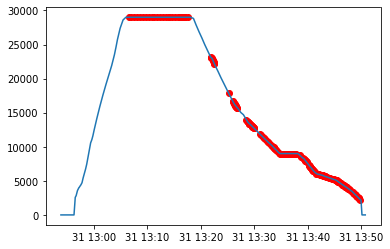

In [163]:
plt.plot(t1.time, t1.alt)
tmp = proc_t[proc_t["initial_seg_point"]==True]
plt.scatter(tmp.time, tmp.alt, color='red')

In [164]:
def segment_level(df, level_band, vertical_speed_band):
    segment_flag = False
    segment_flag_list = []
    for i in range(len(df)-1):
        if not segment_flag and df.iloc[i]["initial_seg_point"]:
            segment_flag = True
            initial_point = df.iloc[i]
        if segment_flag:
            if initial_point["alt"] - df.iloc[i]["alt"] >= level_band:
                segment_flag_list.append(False)
                segment_flag = False
            elif df.iloc[i+1]["vertical_speed"] - df.iloc[i]["vertical_speed"] >= vertical_speed_band:
                segment_flag_list.append(True)
                segment_flag = False
            else:
                segment_flag_list.append(True) 
        else:
            segment_flag_list.append(False)
    segment_flag_list.append(segment_flag)
    return segment_flag_list

In [165]:
proc_t["segment"] = segment_level(proc_t, level_band, vertical_speed_band)

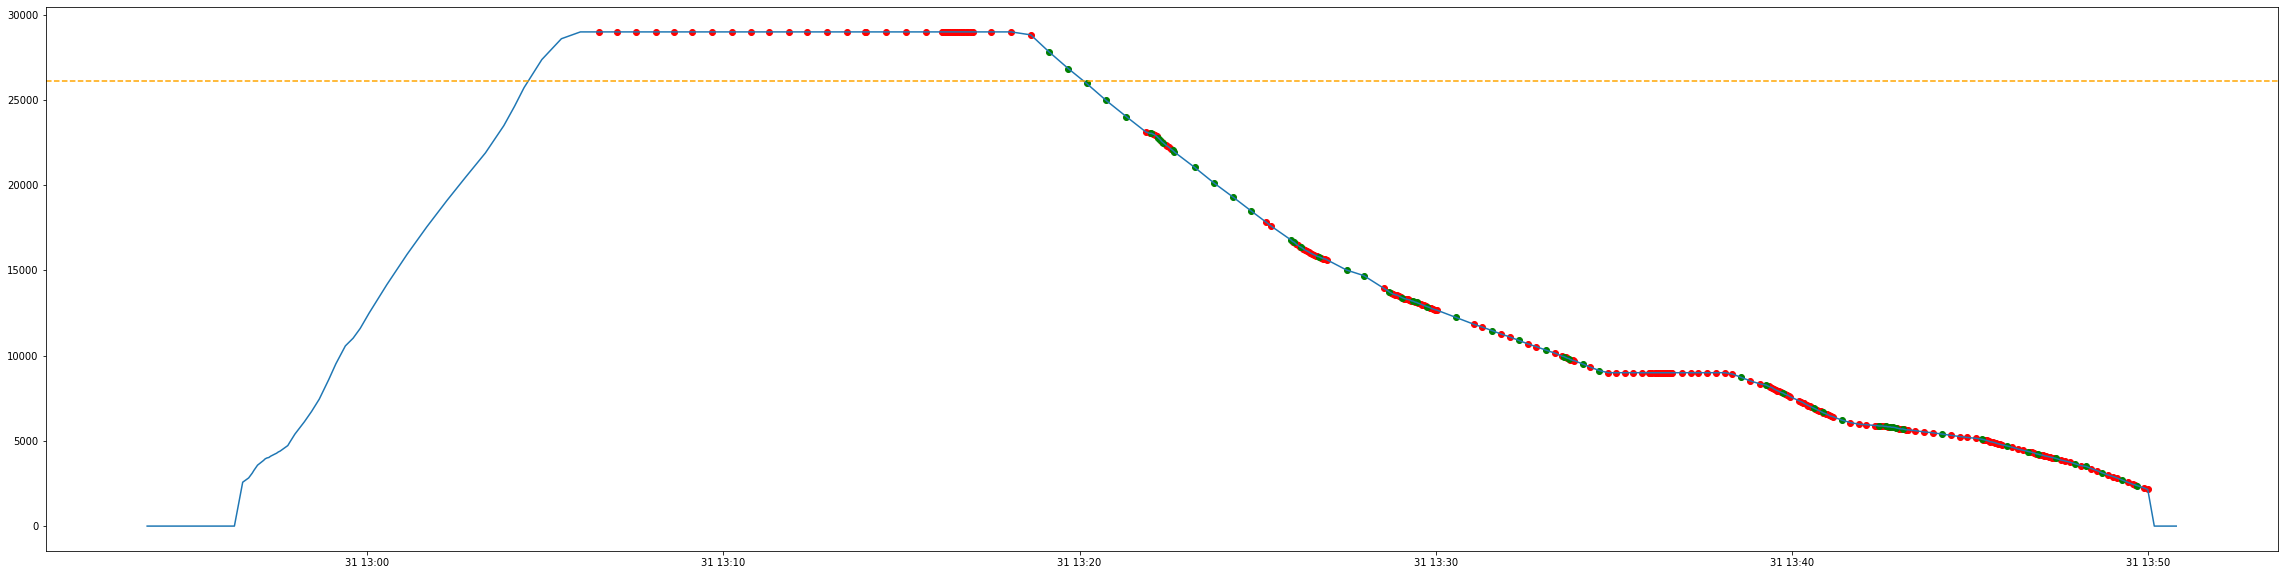

In [166]:
plt.figure(figsize=(40, 10))

plt.plot(t1.time, t1.alt)
tmp = proc_t[proc_t["segment"]==True]
plt.scatter(tmp.time, tmp.alt, color='red')
tmp = proc_t[proc_t["segment"]==False]
plt.scatter(tmp.time, tmp.alt, color='green')
plt.axhline(y=TOC_box_lim, color='orange', linestyle='--', label=f'y = {TOC_box_lim}')

In [167]:
proc_t_without_exclusion_box = proc_t[proc_t["alt"]<TOC_box_lim]

In [168]:
from geopy.distance import geodesic

def validate_segment_and_calculate_distance(df, min_level_time):
    # Converte a coluna 'time' para datetime
    df['time'] = pd.to_datetime(df['time'])

    segment_flag = False
    val_segment = []
    segment_time = []
    segment_distances = []  # Distâncias em milhas náuticas para cada segmento
    initial_time = None
    segment_points_count = 0
    segment_lat_lon = []  # Armazena as coordenadas (lat, lon) do segmento atual

    for i in range(len(df)):
        if not segment_flag and df.iloc[i]["segment"]:  # Início de um segmento
            segment_flag = True
            initial_time = df.iloc[i]["time"]
            segment_points_count = 1
            segment_lat_lon = [(df.iloc[i]["lat"], df.iloc[i]["lon"])]  # Inicia as coordenadas
        elif segment_flag and df.iloc[i]["segment"]:  # Continuação do segmento
            segment_points_count += 1
            segment_lat_lon.append((df.iloc[i]["lat"], df.iloc[i]["lon"]))  # Adiciona coordenadas
        elif segment_flag and not df.iloc[i]["segment"]:  # Fim de um segmento
            segment_flag = False
            final_time = df.iloc[i - 1]["time"]  # Final é o tempo do ponto anterior
            delta_time = (final_time - initial_time).total_seconds()
            
            # Valida o segmento
            val = delta_time >= min_level_time
            val_segment.extend([val] * segment_points_count)  # Marca todo o segmento
            if val:
                segment_time.append(delta_time)  # Registra o tempo válido
                # Calcula a distância do segmento usando geopy
                distance = sum(
                    geodesic(segment_lat_lon[j], segment_lat_lon[j + 1]).nautical
                    for j in range(len(segment_lat_lon) - 1)
                )
                segment_distances.append(distance)
            segment_points_count = 0
            segment_lat_lon = []  # Reseta as coordenadas para o próximo segmento
            
        # Adiciona False para pontos fora de segmentos
        if not segment_flag:
            val_segment.append(False)

    # Caso o último ponto pertença a um segmento
    if segment_flag:
        final_time = df.iloc[-1]["time"]
        delta_time = (final_time - initial_time).total_seconds()
        val = delta_time >= min_level_time
        val_segment.extend([val] * segment_points_count)  # Marca todo o segmento
        if val:
            segment_time.append(delta_time)
            # Calcula a distância do segmento
            distance = sum(
                geodesic(segment_lat_lon[j], segment_lat_lon[j + 1]).nautical
                for j in range(len(segment_lat_lon) - 1)
            )
            segment_distances.append(distance)

    return val_segment, segment_time, segment_distances


In [169]:
proc_t_without_exclusion_box["val_segment"], times_list, distances_list = validate_segment_and_calculate_distance(proc_t_without_exclusion_box, min_level_time)

<ipython-input-168-39a3a4ec0da9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.to_datetime(df['time'])
<ipython-input-169-70dd1c05ff74>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proc_t_without_exclusion_box["val_segment"], times_list, distances_list = validate_segment_and_calculate_distance(proc_t_without_exclusion_box, min_level_time)


In [170]:
# KPI17 - V1
sum(distances_list)

27.77981623820327

In [171]:
# KPI17 - V2
sum(times_list)

490.0

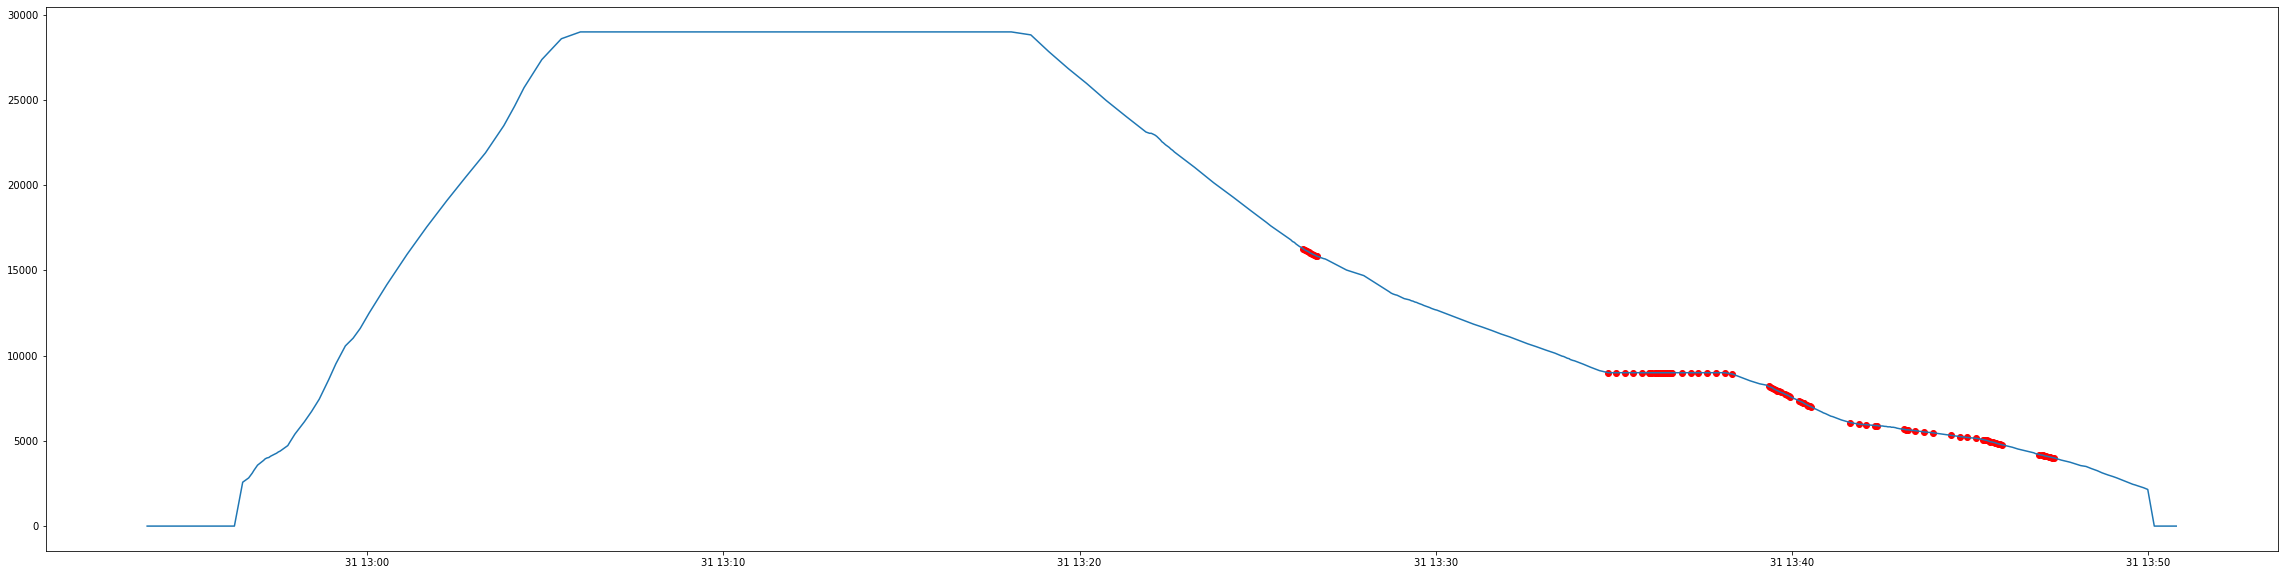

In [172]:
plt.figure(figsize=(40, 10))

plt.plot(t1.time, t1.alt)
tmp = proc_t_without_exclusion_box[proc_t_without_exclusion_box["val_segment"]==True]
plt.scatter(tmp.time, tmp.alt, color='red')